In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from monai.transforms import LoadImaged, Compose, Resized, EnsureChannelFirstd
import numpy as np

# Add the project source to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import your custom transforms
from src.data.transforms import WaveletTransformd

# Set notebook style
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete.")

Setup complete.


In [2]:
# Load environment variables
load_dotenv(dotenv_path='../.env')
IMAGE_ROOT_DIR = os.getenv("MIMIC_CXR_P_FOLDERS_PATH")
PROJECT_DATA_FOLDER_PATH = os.getenv("PROJECT_DATA_FOLDER_PATH")

if not all([IMAGE_ROOT_DIR, PROJECT_DATA_FOLDER_PATH]):
    raise ValueError("Please ensure all required environment variables are set.")

# --- 1. Load data and select a sample with a fracture ---
val_csv_path = os.path.join(PROJECT_DATA_FOLDER_PATH, "splits", "split_2000", "validation.csv")
df_val = pd.read_csv(val_csv_path)

df_fractures = df_val[df_val['fracture'] == 1]
if df_fractures.empty:
    raise ValueError("No fracture cases found in the validation split.")

# Get image path
sample_record = df_fractures.iloc[0]
subject_id = str(int(sample_record['subject_id']))
study_id = str(int(sample_record['study_id']))
dicom_id = str(sample_record['dicom_id'])
image_relative_path = os.path.join(f"p{subject_id[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")
full_image_path = os.path.join(IMAGE_ROOT_DIR, image_relative_path)

sample_dict = {"image": full_image_path}
print(f"Successfully located image with a fracture:\n{full_image_path}")

Successfully located image with a fracture:
E:/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/files\p19\p19175595\s52445151\468a1675-344a56da-7cf12651-0344086a-8454a87a.jpg


In [ ]:
# --- Configuration for Visualization ---
SQUARE_SIZE = 256 # Using a smaller size for quicker visualization
THRESHOLD_RATIO = 0.1 # Using 10% thresholding on details
WAVELET_NAME = "db2" # Using Daubechies wavelet for better detail preservation

# --- Base Preprocessing ---
base_pipeline = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=(SQUARE_SIZE, SQUARE_SIZE)),
])
preprocessed_dict = base_pipeline(sample_dict)
original_image_tensor = preprocessed_dict['image']

# --- Define and Apply NEW wavelet Transform Configurations ---

# Config 1: Decompose into 2 levels
wavelet_transformer_1 = WaveletTransformd(keys=["image"], output_key="wavelet_1", levels=2, input_original_image=False, wavelet_name=WAVELET_NAME)
result_1 = wavelet_transformer_1(preprocessed_dict.copy())
print(f"Config 1 (2 levels) -> Output shape: {result_1['wavelet_1'].shape}")


# Config 2: Decompose into 2 levels AND include the original image
wavelet_transformer_2 = WaveletTransformd(keys=["image"], output_key="wavelet_2", levels=2, input_original_image=True, wavelet_name=WAVELET_NAME)
result_2 = wavelet_transformer_2(preprocessed_dict.copy())
print(f"Config 2 (2 levels + Original) -> Output shape: {result_2['wavelet_2'].shape}")


# Config 3: Decompose using max levels and thresholding
wavelet_transformer_3 = WaveletTransformd(keys=["image"], output_key="wavelet_3", levels=None, threshold_ratio=THRESHOLD_RATIO, wavelet_name=WAVELET_NAME)
result_3 = wavelet_transformer_3(preprocessed_dict.copy())
print(f"Config 3 (Max levels + Thresholding) -> Output shape: {result_3['wavelet_3'].shape}")

print("\nAll transform configurations applied successfully.")

Config 1 (2 levels) -> Output shape: torch.Size([7, 256, 256])
Config 2 (2 levels + Original) -> Output shape: torch.Size([8, 256, 256])
Config 3 (Max levels + Thresholding) -> Output shape: torch.Size([25, 256, 256])

All transform configurations applied successfully.


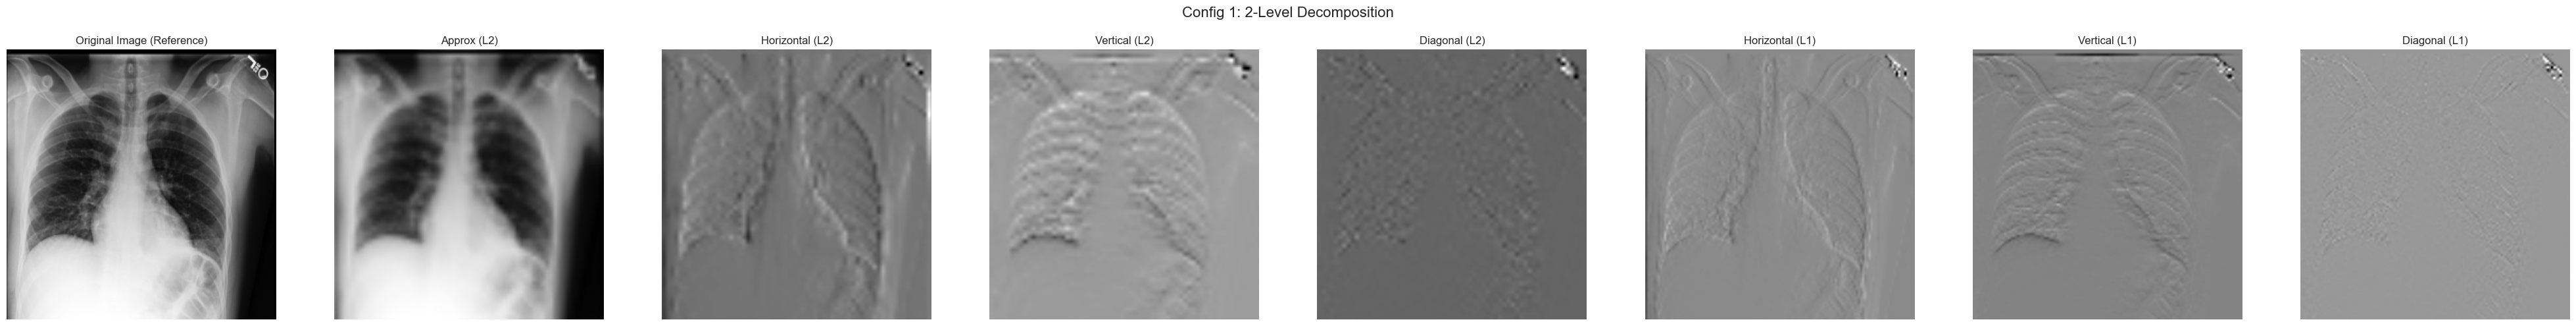

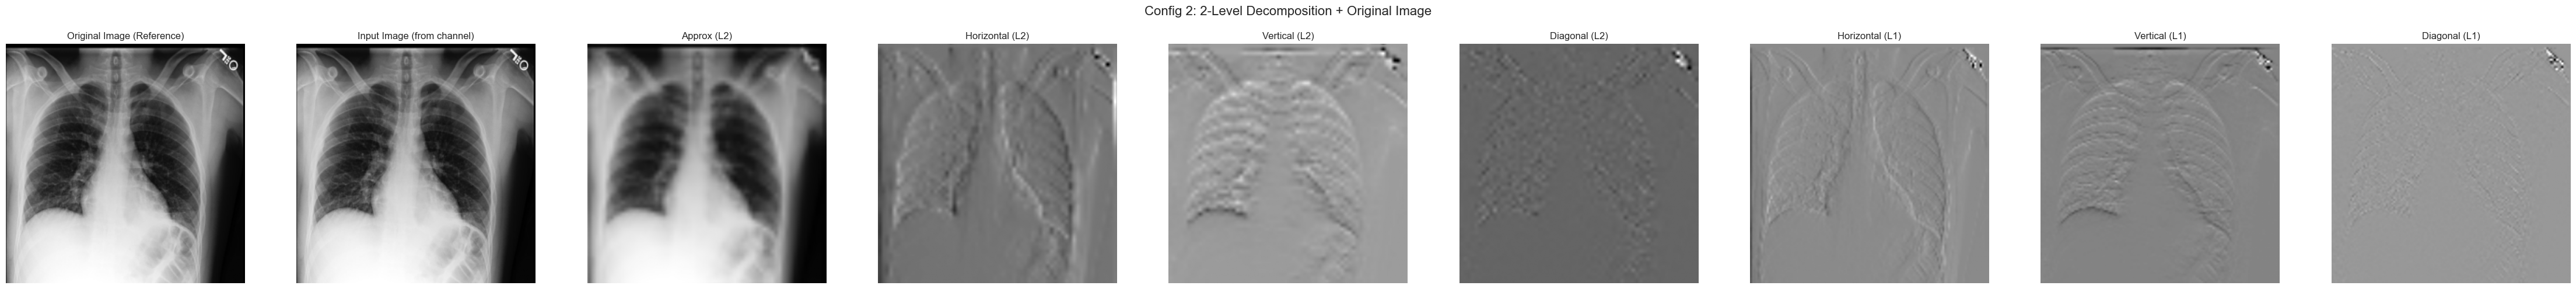

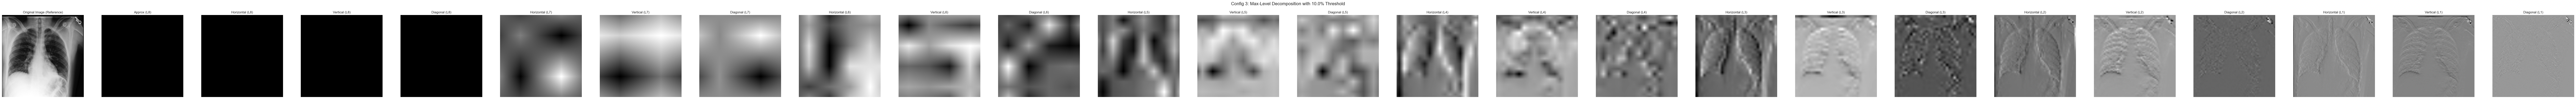

In [4]:
def plot_transform_results(original_img_np: np.ndarray, transformed_tensor: torch.Tensor, config_title: str, levels: int, includes_original: bool = False):
    """
    Helper function to visualize the multi-channel output of the WaveletTransformd.
    """
    num_channels = transformed_tensor.shape[0]
    
    # Determine titles for each subplot
    if includes_original:
        max_level = levels
        titles = ["Input Image (from channel)"]
        titles.append(f"Approx (L{max_level})")
        for i in range(max_level, 0, -1):
            titles.extend([f"Horizontal (L{i})", f"Vertical (L{i})", f"Diagonal (L{i})"])
    else:
        max_level = levels if levels is not None else int((num_channels-1)/3)
        titles = [f"Approx (L{max_level})"]
        for i in range(max_level, 0, -1):
            titles.extend([f"Horizontal (L{i})", f"Vertical (L{i})", f"Diagonal (L{i})"])

    # Create figure
    fig, axes = plt.subplots(1, num_channels + 1, figsize=(5 * (num_channels + 1), 5))
    fig.suptitle(config_title, fontsize=16)

    # Plot original image for reference
    axes[0].imshow(original_img_np.T, cmap='gray')
    axes[0].set_title("Original Image (Reference)")
    axes[0].axis('off')

    # Plot each channel from the transformed tensor
    for i in range(num_channels):
        ax = axes[i+1]
        ax.imshow(transformed_tensor[i].squeeze().numpy().T, cmap='gray')
        ax.set_title(titles[i] if i < len(titles) else f"Channel {i+1}")
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Visualize the results of each configuration ---
original_np = original_image_tensor.squeeze().numpy()

# Plot for Config 1
plot_transform_results(original_np, result_1['wavelet_1'], "Config 1: 2-Level Decomposition", levels=2, includes_original=False)

# Plot for Config 2
plot_transform_results(original_np, result_2['wavelet_2'], "Config 2: 2-Level Decomposition + Original Image", levels=2, includes_original=True)

# Plot for Config 3
plot_transform_results(original_np, result_3['wavelet_3'], f"Config 3: Max-Level Decomposition with {THRESHOLD_RATIO*100}% Threshold", levels=None, includes_original=False)